In [1]:
import numpy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D 

# Closure Simulations

The purpose of this simulation is to see if a lack of redundancy in the telescope can cause a similar effect to what I see in the HERA data.

We will start by generating some electric fields at locations that correspond to a HERA-like layout. We will use a gaussian beam first, then switch to using a different beam for each telescope and see what happens.

Then we will look at different sky layouts and how that shakes things up.

In [2]:
# For simulating Electric Fields
def simulate_electric_fields(locations_uvw,points):
    elec_ss = numpy.zeros(shape=(locations_uvw.shape[0]),dtype=numpy.complex128)
    
    for i in numpy.arange(locations_uvw.shape[0]):
        for point in points:
            l = point[0]
            m = point[1]
            n = numpy.sqrt(1.0-l**2-m**2) - 1.0
            amp = point[2]
            u = locations_uvw[i,0]
            v = locations_uvw[i,1]
            w = locations_uvw[i,2]
            elec_ss[i] += amp*numpy.exp(-2j*numpy.pi*(u*l+v*m+w*n))
    return elec_ss

# 7 Antennas
def generate_hera_layout_simple():
    layout_vec = numpy.zeros(shape=(14,3))
    
    
    layout_vec[0] = numpy.asarray([-7,24.2486,0])
    layout_vec[1] = numpy.asarray([7,24.2486,0])
    layout_vec[2] = numpy.asarray([-14,12.1243,0])
    layout_vec[3] = numpy.asarray([0,12.1243,0])
    layout_vec[4] = numpy.asarray([14,12.1243,0])
    layout_vec[5] = numpy.asarray([-21,0,0])
    layout_vec[6] = numpy.asarray([-7,0,0])
    layout_vec[7] = numpy.asarray([7,0,0])
    layout_vec[8] = numpy.asarray([21,0,0])
    layout_vec[9] = numpy.asarray([-14,-12.1243,0])
    layout_vec[10] = numpy.asarray([0,-12.1243,0])
    layout_vec[11] = numpy.asarray([14,-12.1243,0])
    layout_vec[12] = numpy.asarray([-7,-24.2486,0])
    layout_vec[13] = numpy.asarray([7,-24.2486,0])

    
    
    return layout_vec

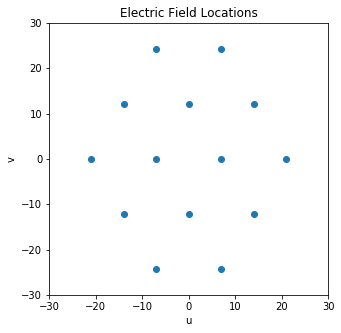

In [3]:
locs = generate_hera_layout_simple()
us = locs[:,0]
vs = locs[:,1]
ws = locs[:,2]
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(us,vs)
ax.set_title('Electric Field Locations')
ax.set_xlim([-30,30])
ax.set_ylim([-30,30])
ax.set_xlabel('u'); ax.set_ylabel('v');# ax.set_zlabel('v'); 

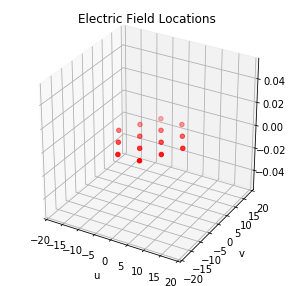

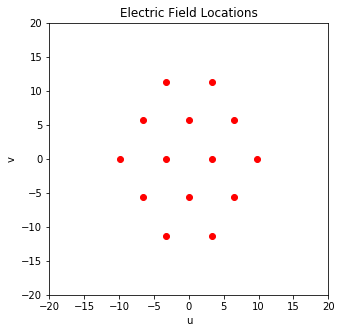

In [4]:
frequency = 140e6 # Let's just do this in a single channel for now.
chan_bw = 25e3

wavelength = 3e8 / frequency

locs_uvw = locs/wavelength

us_uvw = locs_uvw[:,0]
vs_uvw = locs_uvw[:,1]
ws_uvw = locs_uvw[:,2]

fig, ax = plt.subplots(figsize=(5,5),subplot_kw={'projection': '3d'})
ax.scatter(us_uvw,vs_uvw,ws_uvw,color='red')
ax.set_title('Electric Field Locations')
ax.set_xlim([-20,20])
ax.set_ylim([-20,20])
ax.set_xlabel('u'); ax.set_ylabel('v');
plt.show()

fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(us_uvw,vs_uvw,color='red')
ax.set_title('Electric Field Locations')
ax.set_xlim([-20,20])
ax.set_ylim([-20,20])
ax.set_xlabel('u'); ax.set_ylabel('v');
plt.show()

Now let's try and generate some sort of beam to work with.

(2000,)


/usr/local/lib/python3.7/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


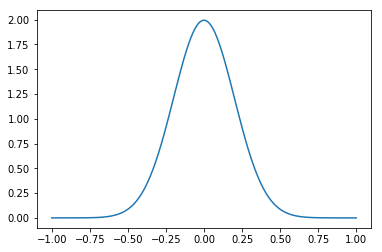

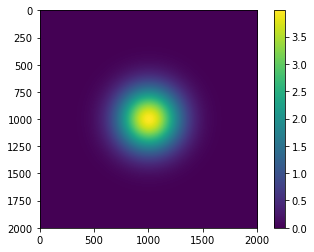

In [5]:
from scipy.stats import norm

def generate_gaussian_beam():

    x = numpy.linspace(-1,1,2000)
    return x,norm.pdf(x, loc=0, scale=0.2)+ 1j*norm.pdf(x, loc=0,scale=0.2)#*norm.cdf(2*x,loc=0,scale=0.2) + 1j*norm.pdf(x, loc=0,scale=0.2)#*norm.cdf(2*x,loc=0,scale=0.2)

def find_beam_at_point(beam,point):
    beam_shape = beam.shape[0]
    
    pl = point[0]
    pm = point[1]
    
    step = 2/beam_shape
    
    bl_ind = int((pl + 1)/step)
    bm_ind = int((pm + 1)/step)
    
    # Multiple real/imaginary seperately. 
    
    re_be = beam[bl_ind].real * beam[bm_ind].real
    im_be = beam[bl_ind].imag * beam[bm_ind].imag    
    
    return re_be + 1j * im_be

    
angle, beam = generate_gaussian_beam()
print(angle.shape)
plt.plot(angle, beam)
plt.show()

# 2D one too

beam_re = numpy.outer(beam.real,beam.real.T)
beam_im = numpy.outer(beam.imag,beam.imag.T)
#beam_2D = numpy.outer(beam,beam.T.conj())
beam_2D = beam_re + 1j * beam_im
plt.imshow(beam_2D.real)
plt.colorbar()
plt.show()

In [6]:
# For simulating Electric Fields
def simulate_electric_fields_gaussianbeam(locations_uvw,points,beam):
    elec_ss = numpy.zeros(shape=(locations_uvw.shape[0]),dtype=numpy.complex128)
    phase_source = numpy.zeros(shape=(points.shape[0]),dtype=numpy.complex128)
    print(phase_source.shape)
    for i in numpy.arange(points.shape[0]):
        phase_source[i] = numpy.exp(2*numpy.pi * numpy.random.uniform(0,1))
    
    for i in numpy.arange(locations_uvw.shape[0]):
        #print(locations_uvw[i,:])
        #numpy.random.seed(12345)
        #antenna_noise = 500*(numpy.random.normal(scale=4000.0) + 1j * numpy.random.normal(scale=4000.0))
        #antenna_phase_noise = numpy.exp(1j*numpy.random.uniform(-0.1,0.1))
        #antenna_noise = 0
        
        for j,point in enumerate(points):
            #print(j)
            l = point[0]
            m = point[1]
            n = numpy.sqrt(1.0-l**2-m**2) - 1.0
            u = locations_uvw[i,0]
            v = locations_uvw[i,1]
            w = locations_uvw[i,2]
            elec_ss[i] += point[2]*numpy.exp(-2j*numpy.pi*(u*l+v*m+w*n))  * find_beam_at_point(beam,point)# * numpy.exp(2*numpy.pi * numpy.random.uniform(0,1)) #* numpy.random.uniform(0.9,1.1)
        #elec_ss[i] += antenna_noise #* antenna_phase_noise
    return elec_ss

In [7]:
points = [[0.2,0.2,80],[0.05,0.3,40],[-0.45,0.45,790],[0.45,0.45,100],[0.45,-0.45,100],
          [-0.45,-0.45,100],[0.5,0.0,100],[0.0,0.5,80],[-0.5,0.0,100],[-0.5,-0.5,100],
          [-0.8,0.0,100],[0.8,0.0,100],[0.21,0.21,80],[0.205,0.205,100]]
#points = [[0.1,0.2,100]]
#points = [[0.0,0.0,1],[0.48,0.49,4],[0.47,0.49,4],[0.48,0.48,4]]
efields = simulate_electric_fields_gaussianbeam(locs_uvw,numpy.asarray(points),beam)

(14,)


In [8]:
print(efields)
print(numpy.abs(efields))
print(locs_uvw)

[-510.91620157  -5.39504243j  168.01527828+306.62282093j
 -202.29932638+395.1139023j   428.5464519  -43.50065145j
 -323.39959391-303.19075801j  308.27218686+329.70188349j
   87.56126371-458.80363664j -458.80363664 +87.56126371j
  329.70188349+308.27218686j -303.19075801-323.39959391j
  -43.50065145+428.5464519j   395.1139023 -202.29932638j
  306.62282093+168.01527828j   -5.39504243-510.91620157j]
[510.94468537 349.63793852 443.89189365 430.74861359 443.29666487
 451.37021742 467.0843092  467.0843092  451.37021742 443.29666487
 430.74861359 443.89189365 349.63793852 510.94468537]
[[ -3.26666667  11.31601333   0.        ]
 [  3.26666667  11.31601333   0.        ]
 [ -6.53333333   5.65800667   0.        ]
 [  0.           5.65800667   0.        ]
 [  6.53333333   5.65800667   0.        ]
 [ -9.8          0.           0.        ]
 [ -3.26666667   0.           0.        ]
 [  3.26666667   0.           0.        ]
 [  9.8          0.           0.        ]
 [ -6.53333333  -5.65800667   0.    

DFT Sky to see what it looks like

In [9]:
def epic_image_dft(theta,lam,efield,locations):
    grid_size = int(theta*lam)
    image = numpy.zeros(shape=(grid_size,grid_size),dtype=numpy.complex128)
    
    for lg in numpy.arange(grid_size):
        
        lv = (1.0 / (0.5*grid_size)) * (lg - grid_size/2)
        print(lv)
        for mg in numpy.arange(grid_size):
            mv = (1.0/ (0.5*grid_size)) * (mg - grid_size/2)
            if (lv**2 + mv**2 > 1.0):
                continue
                
            else:
                nv = 1.0 - numpy.sqrt(1.0 - lv**2 - mv**2)
            #print(nv)
            for j,efieldd in enumerate(efield):
                u = locations[j,0]
                v = locations[j,1]
                w = locations[j,2]
                #w = 0
                image[lg,mg] += efieldd * numpy.exp(2j*numpy.pi*(u*lv + v*mv + w*nv))
    return image / (grid_size**2)

In [10]:
image = epic_image_dft(2,32,efields,locs_uvw)

-1.0
-0.96875
-0.9375
-0.90625
-0.875
-0.84375
-0.8125
-0.78125
-0.75
-0.71875
-0.6875
-0.65625
-0.625
-0.59375
-0.5625
-0.53125
-0.5
-0.46875
-0.4375
-0.40625
-0.375
-0.34375
-0.3125
-0.28125
-0.25
-0.21875
-0.1875
-0.15625
-0.125
-0.09375
-0.0625
-0.03125
0.0
0.03125
0.0625
0.09375
0.125
0.15625
0.1875
0.21875
0.25
0.28125
0.3125
0.34375
0.375
0.40625
0.4375
0.46875
0.5
0.53125
0.5625
0.59375
0.625
0.65625
0.6875
0.71875
0.75
0.78125
0.8125
0.84375
0.875
0.90625
0.9375
0.96875


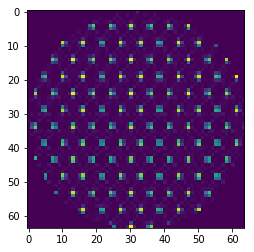

In [11]:
plt.imshow((image * image.conj()).real)
plt.show()

Dreadful but expected considering HERA's PSF is rubbish.

## Visibilities

Let's start making some visibilities up

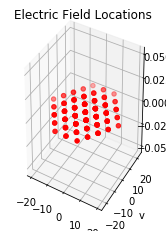

In [12]:
visibilities = numpy.outer(efields,efields.T.conj())

def generate_baseline_vectors(locations):
    
    loc_no = locations.shape[0]
    baseline_vectors = numpy.zeros(shape=(loc_no, loc_no,3))
    
    for i in numpy.arange(loc_no):
        for j in numpy.arange(loc_no):
            baseline_vectors[i,j,0] = (locations[i,0] - locations[j,0])#/2
            baseline_vectors[i,j,1] = (locations[i,1] - locations[j,1])#/2
            baseline_vectors[i,j,2] = (locations[i,2] - locations[j,2])#/2
            
    return baseline_vectors


def plot_baselines(baselines):
    
    us = baselines[:,:,0]
    vs = baselines[:,:,1]
    ws = baselines[:,:,2]
    ax = plt.subplot(121, projection='3d')
    ax.scatter(us,vs,ws, color='red')
    ax.set_title('Electric Field Locations')
    ax.set_xlabel('u'); ax.set_ylabel('v'); ax.set_zlabel('w')
    plt.show()
    

baselines = generate_baseline_vectors(locs_uvw)
plot_baselines(baselines)

In [13]:
baselines_ew_14m = numpy.asarray([[0,1],[2,3],[3,4],[5,6]])
visibilities_ew_14m = visibilities[baselines_ew_14m[:,0],baselines_ew_14m[:,1]]

In [14]:
print(visibilities.shape)

(14, 14)


## Closure Phases

Closure phases can be generated by multipling three visibilities from a set of baselines comprising three antennas in a closed geometric triangle.

The phase of the resulting complex number is taken and provides our closure phase for each 'triad'

Should do as Bojan does and just give each antenna an id, in this case comensurate with its position in the array and extract the baselines I care about. 



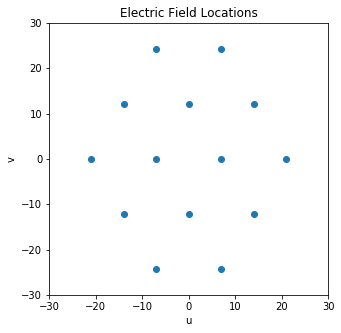

In [15]:
us = locs[:,0]
vs = locs[:,1]
ws = locs[:,2]
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(us,vs)
ax.set_title('Electric Field Locations')
ax.set_xlim([-30,30])
ax.set_ylim([-30,30])
ax.set_xlabel('u'); ax.set_ylabel('v');# ax.set_zlabel('v'); 

In [16]:
List_of_antennas = [[[0,2],[2,3],[3,0]],
                    [[1,3],[3,4],[4,1]],
                    [[2,5],[5,6],[6,2]],
                    [[3,6],[6,7],[7,3]],
                    [[4,7],[7,8],[8,4]],
                    [[6,9],[9,10],[10,6]],
                    [[7,10],[10,11],[11,7]],
                    [[10,12],[12,13],[13,10]]]

In [17]:
def generate_closure_triads(visb,antenna_list):
    
    ant_list = numpy.asarray(antenna_list)
    triads = numpy.zeros(shape=ant_list.shape[0])
    for i,triadconfig in enumerate(ant_list):
        vis1l = triadconfig[0]
        vis2l = triadconfig[1]
        vis3l = triadconfig[2]
        #print(triadconfig)
        vis1 = numpy.angle(visb[vis1l[0],vis1l[1]])
        vis2 = numpy.angle(visb[vis2l[0],vis2l[1]])
        vis3 = numpy.angle(visb[vis3l[0],vis3l[1]])
        print(vis1,vis2,vis3)
        triads[i] = vis1 + vis2 + vis3
        
    return triads

def generate_closure_triads_tp(visb,antenna_list):
    
    ant_list = numpy.asarray(antenna_list)
    triads = numpy.zeros(shape=ant_list.shape[0])
    for i,triadconfig in enumerate(ant_list):
        vis1l = triadconfig[0]
        vis2l = triadconfig[1]
        vis3l = triadconfig[2]
        #print(triadconfig)
        triple_product = numpy.angle(visb[vis1l[0],vis1l[1]] * visb[vis2l[0],vis2l[1]] * visb[vis3l[0],vis3l[1]])
        vis1 = numpy.arctan2(numpy.sin(triple_product),numpy.cos(triple_product))
        #vis2 = numpy.angle(visb[vis2l[0],vis2l[1]])
        #vis3 = numpy.angle(visb[vis3l[0],vis3l[1]])
        #print(vis1,vis2,vis3)
        triads[i] = vis1# + vis2 + vis3
        
    return triads

def calculate_closure_standard_deviation(closures):
    xc = numpy.cos(closures)
    yc = numpy.sin(closures)
    
    conc = numpy.sqrt(numpy.square(numpy.mean(xc)) + numpy.square(numpy.mean(yc)))
    return numpy.sqrt(-2 * numpy.log(conc))
    
    

In [18]:
closures = generate_closure_triads(visibilities,List_of_antennas)
closures1 = generate_closure_triads_tp(visibilities,List_of_antennas)

1.1081519984439603 2.1451607466607747 3.0298725620748512
1.1706860442676243 2.287274445031919 2.825224817880043
1.225024037345867 2.201192860093073 2.8569684097406465
1.2810561507781653 1.9479548001585538 3.0541743562428674
0.9417365059048001 2.201192860093073 3.1402559411817133
0.9417365059048001 2.287274445031919 3.0541743562428674
1.2810561507781653 2.1451607466607747 2.8569684097406465
1.1706860442676243 2.082626700837111 3.0298725620748512


In [19]:
print(closures)
print(closures1)

[6.28318531 6.28318531 6.28318531 6.28318531 6.28318531 6.28318531
 6.28318531 6.28318531]
[ 7.85798665e-17  0.00000000e+00  0.00000000e+00  0.00000000e+00
  4.74046142e-17  1.25710843e-16 -3.13434825e-17  1.05547358e-16]


Zero closures? Seems suspicious. Let's try screwing up the beam shapes and see what happens.
Let's make a different gaussian beam for each antenna and see what happens.

In [20]:
def generate_beam_per_antenna(locs,lb,ub):
    beams_matrix = numpy.zeros(shape=(locs.shape[0],2000),dtype=numpy.complex128)
    
    x = numpy.linspace(-1,1,2000)
    
    for i in numpy.arange(locs.shape[0]):
        #a1 = numpy.random.uniform(-2.0,2.0)
        #a2 = numpy.random.uniform(-2.0,2.0)
        beamr = norm.pdf(x, loc=0, scale=numpy.random.uniform(lb,ub))#*norm.cdf(a1*x)
        beamp = norm.pdf(x, loc=0, scale=numpy.random.uniform(lb,ub))#*norm.cdf(a2*x)
        #beams_matrix[i,:] = beamr * numpy.exp(1j * beamp)
        beams_matrix[i,:] = beamr + 1j * beamp
        #plt.plot(x, beams_matrix[i,:].real)
        #plt.show()
        #plt.plot(x, beams_matrix[i,:].imag)
        #plt.show()
    
    return x,beams_matrix

In [21]:
x,beams = generate_beam_per_antenna(locs,0.9,1.1)

In [22]:
print(beams[2])

[0.2398642 +0.24170315j 0.24015193+0.24196143j 0.24043972+0.24221972j ...
 0.24043972+0.24221972j 0.24015193+0.24196143j 0.2398642 +0.24170315j]


In [23]:
# For simulating Electric Fields
def simulate_electric_fields_different_beams(locations_uvw,points,beam_matrices):
    elec_ss = numpy.zeros(shape=(locations_uvw.shape[0]),dtype=numpy.complex128)
    
    phase_source = numpy.zeros(shape=(points.shape[0]),dtype=numpy.complex128)
    print(phase_source.shape)
    for i in numpy.arange(points.shape[0]):
        phase_source[i] = numpy.exp(-1j*numpy.random.uniform(0,2*numpy.pi))
    
    for i in numpy.arange(locations_uvw.shape[0]):
        
        antenna_noise = numpy.random.normal(scale=4000.0)# + 1j * numpy.random.normal(scale=2000.0)
        for j,point in enumerate(points):
            l = point[0]
            m = point[1]
            n = numpy.sqrt(1.0-l**2-m**2) - 1.0
            bap = find_beam_at_point(beam_matrices[i,:],point)
            #print(bap)
            amp = point[2]
            #print(amp)
            u = locations_uvw[i,0]
            v = locations_uvw[i,1]
            w = locations_uvw[i,2]
            elec_ss[i] += amp*numpy.exp(-2j*numpy.pi*(u*l+v*m+w*n)) * bap * phase_source[j]
        #elec_ss[i] += antenna_noise
    return elec_ss

In [24]:
#beams[7,:] = 0.0

efields_db = simulate_electric_fields_different_beams(locs_uvw,numpy.asarray(points),beams)
print(efields_db)


(14,)
[ -48.80041618-103.37763766j  -64.07914925 -40.89383869j
  -45.60502149-163.11155402j    3.58112312-209.17433723j
  -86.61408374-109.86661098j  129.43696027-156.86602046j
  -20.11396114-205.44170478j -115.82202401-121.5563705j
  -31.07216232-104.55368964j   -9.08982083-206.05349616j
   43.75926616-141.07563669j  -24.68852252-158.54825224j
  125.95070021-152.61424029j  -41.62310105-195.04541202j]


In [25]:
visibilities_db = numpy.outer(efields_db,efields_db.T.conj()) 

# Show how adding a correlated noise breaks the closure relationship.
visibilities_db = visibilities_db + 5*(numpy.random.randn(visibilities_db.shape[0],visibilities_db.shape[1]) + 1j*numpy.random.randn(visibilities_db.shape[0],visibilities_db.shape[1]))

In [26]:
closures_db = generate_closure_triads(visibilities_db,List_of_antennas)
closures_db1 = generate_closure_triads_tp(visibilities_db,List_of_antennas)

-0.16843946439290677 -0.2894712750554963 0.4584067833618527
-1.0197849642514727 0.6848644262045938 0.33519380122886605
-0.9622437076407251 0.7875101558774958 0.17497673965166022
0.11463653510342355 0.6636493689227257 -0.7782947075747239
0.09358655095598477 -0.4726187677131159 0.3790657119252277
-0.05346290804370545 -0.3451705542800909 0.39810587766467687
-1.0617708044148417 0.4551554724521286 0.6068185036794422
-0.38936605043254685 0.9000963740380652 -0.5109585586451248


In [27]:
print(closures_db)
print(closures_db1)

[ 4.96043913e-04  2.73263182e-04  2.43187888e-04 -8.80354857e-06
  3.34951681e-05 -5.27584659e-04  2.03171717e-04 -2.28235040e-04]
[ 4.96043913e-04  2.73263182e-04  2.43187888e-04 -8.80354857e-06
  3.34951681e-05 -5.27584659e-04  2.03171717e-04 -2.28235040e-04]


# This makes sense as I have only added direction-independent noise apart from each sources own phase. 

We can break closure by including correlated baseline terms, especially correlated baseline noise, which casuses closures to diverge. 

But the beam shapes require a more complicated sky model to explore.

## Let's try doing some continuum modelling

In [28]:
# Generate a sky model
# We assume this sky is an entire celestial hemisphere.
# Points are [[l1,m1,amp1],[l2,m2,amp2]]
# Continuum is in the form of [[l,m,support,scale,amp],...] The amp has some random fluctuation imposed on it
def generate_continuum_model(grid_size,points,continuum):
    
    # Each axis runs from -1 to 1, l/m respectively.
    sky = numpy.zeros(shape=(grid_size,grid_size),dtype=numpy.complex128)
    
    lm_step = 2/grid_size
    
    # First generate points
    for j,point in enumerate(points):
        
        l = point[0]
        m = point[1]
        if(l**2 + m**2 > 1):
            continue
        lc = int(numpy.floor(l/lm_step) - grid_size/2)
        mc = int(numpy.floor(m/lm_step) - grid_size/2)
        
        point_phase = numpy.random.uniform(0,2*numpy.pi)
        sky[mc,lc] += point[2] * numpy.exp(point_phase)
        
    # Now place down continuum emission
    for j,contin in enumerate(continuum):
    
        l = contin[0]
        m = contin[1]
        support=contin[2]
        scale = contin[3]
        amp = contin[4]
        x = numpy.linspace(-support//2,support//2,support)
        gaussian = amp * (norm.pdf(x, loc=0, scale=scale)) * norm.cdf(4*x,loc=0,scale=scale)
        gaussian2d = numpy.outer(gaussian,gaussian.T)
        
        lc = int(numpy.floor(l/lm_step) - grid_size/2)
        mc = int(numpy.floor(m/lm_step) - grid_size/2)
        for cm in numpy.arange(-support//2,support//2):           
            for cl in numpy.arange(-support//2,support//2):            
                sky[mc+cm,lc+cl] += gaussian2d[int(cm+support//2),int(cl+support//2)] * numpy.exp(-1j*numpy.random.uniform(0,numpy.pi/8))
                
    return sky
                
    
    

In [29]:
continuums = [[-0.01,-0.02,64,16,1000],[0.01,0.02,64,16,1000],[-0.4,-0.4,64,70,1000],[-0.5,0.2,16,9.5,1000],[-0.3,-0.1,64,7.2,1000]]

In [30]:
skycont = generate_continuum_model(512,points,continuums)

<function matplotlib.pyplot.show(*args, **kw)>

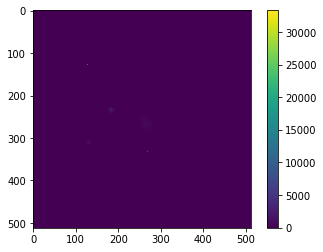

In [31]:
plt.imshow(numpy.real(skycont))
plt.colorbar()
plt.show

In [32]:
print(numpy.abs(visibilities))

[[261064.47150768 178645.64648958 226804.20393866 220088.71484458
  226500.07495756 230625.21372384 238654.2454053  238654.2454053
  230625.21372384 226500.07495756 220088.71484458 226804.20393866
  178645.64648958 261064.47150768]
 [178645.64648958 122246.68805131 155201.44662038 150606.05727545
  154993.33205721 157816.1523265  163310.39498286 163310.39498286
  157816.1523265  154993.33205721 150606.05727545 155201.44662038
  122246.68805131 178645.64648958]
 [226804.20393866 155201.44662038 197040.01324721 191205.8177734
  196775.79601744 200359.5805463  207334.93850441 207334.93850441
  200359.5805463  196775.79601744 191205.8177734  197040.01324721
  155201.44662038 226804.20393866]
 [220088.71484458 150606.05727545 191205.8177734  185544.36811028
  190949.42380217 194427.09536883 201195.91861778 201195.91861778
  194427.09536883 190949.42380217 185544.36811028 191205.8177734
  150606.05727545 220088.71484458]
 [226500.07495756 154993.33205721 196775.79601744 190949.42380217
  196

I mean it's not exactly something Carl Sagan would drool over but I think it should suffice to prove the mathematics here

In [33]:
# For simulating Electric Fields
def simulate_electric_fields_fromsky_gaussianbeam(locations_uvw,sky,beam):
    elec_ss = numpy.zeros(shape=(locations_uvw.shape[0]),dtype=numpy.complex128)
    grid_size = sky.shape[0]
    lm_step = 2/grid_size
    for i in numpy.arange(locations_uvw.shape[0]):
        #print(locations_uvw[i,:])
        #numpy.random.seed(12345)
        antenna_noise = 5000*(numpy.random.normal(scale=4000.0) + 1j * numpy.random.normal(scale=4000.0))
        #antenna_noise = 0
        
        for lc in numpy.arange(grid_size):
            l = (lc-grid_size//2) * lm_step
            for mc in numpy.arange(grid_size):
                m = (mc-grid_size//2) * lm_step
                if(l**2 + m**2 > 1):
                    continue
                n = numpy.sqrt(1.0-l**2-m**2) - 1.0
                u = locations_uvw[i,0]
                v = locations_uvw[i,1]
                w = locations_uvw[i,2]
                elec_ss[i] += sky[mc,lc]*numpy.exp(-2j*numpy.pi*(u*l+v*m+w*n)) * find_beam_at_point(beam,[l,m,0])
        elec_ss[i] += antenna_noise
    return elec_ss/grid_size**2

# For simulating Electric Fields
def simulate_electric_fields_fromsky_different_beams(locations_uvw,sky,beam_matrices):
    elec_ss = numpy.zeros(shape=(locations_uvw.shape[0]),dtype=numpy.complex128)
    grid_size = sky.shape[0]
    lm_step = 2/grid_size
    for i in numpy.arange(locations_uvw.shape[0]):
        
        antenna_noise = numpy.random.normal(scale=4000.0)# + 1j * numpy.random.normal(scale=2000.0)
        for lc in numpy.arange(grid_size):
            l = (lc-grid_size//2) * lm_step
            for mc in numpy.arange(grid_size):
                m = (mc-grid_size//2) * lm_step
                if(l**2 + m**2 > 1):
                    continue
                n = numpy.sqrt(1.0-l**2-m**2) - 1.0
                bap = find_beam_at_point(beam_matrices[i,:],[l,m,0])
                #print(amp)
                u = locations_uvw[i,0]
                v = locations_uvw[i,1]
                w = locations_uvw[i,2]
                elec_ss[i] += sky[mc,lc]*numpy.exp(-2j*numpy.pi*(u*l+v*m+w*n)) * find_beam_at_point(beam,[l,m,0]) 
        elec_ss[i] += antenna_noise
    return elec_ss/grid_size**2

In [34]:
efields_continuum = simulate_electric_fields_fromsky_gaussianbeam(locs_uvw,skycont,beam)

In [35]:
efields_continuum

array([-33.70308519+112.07264096j, -26.99034979+144.0008221j ,
         6.59789981 +65.11640726j, -25.49901873 +22.6957201j ,
        82.07858508 +17.43948742j,  52.5997513  -80.63683511j,
       -25.71476779  -7.80888746j,  67.0366003  +22.69258188j,
       100.16885217 +32.10119996j,  64.8260003  -35.453412j  ,
       -21.60187789  +4.31000344j, -54.31178809 -43.40672755j,
       -28.85175197 +51.43553045j,   5.74298334 +82.25081088j])

In [36]:
visibilities_continuum = numpy.outer(efields_continuum,efields_continuum.T.conj())

In [37]:
closures_continuum = generate_closure_triads(visibilities_continuum,List_of_antennas)
closures_continuum_tp = generate_closure_triads_tp(visibilities_continuum,List_of_antennas)

0.3931021829831094 -0.9444788244542739 0.5513766414711645
-0.6582165939779941 2.2049354884302512 -1.546718894452257
2.4626192152784836 1.8539663657849694 1.9665997261161334
-1.0221209016618595 3.110013403302915 -2.0878925016410554
-0.11704298678919589 0.016272570451460546 0.1007704163377353
-2.3463083910089075 2.8380655706993356 -0.49175717969042826
-2.6182562236124864 -0.871195169245592 -2.793733914321508
0.8626661788887999 0.5809059938891115 -1.4435721727779114


In [38]:
print(closures_continuum)
print(closures_continuum_tp)

[ 0.00000000e+00  0.00000000e+00  6.28318531e+00  0.00000000e+00
 -4.16333634e-17 -1.66533454e-16 -6.28318531e+00  0.00000000e+00]
[ 0.00000000e+00  8.39333053e-17 -1.33025355e-16  5.65575812e-17
 -5.86560670e-17  6.23100673e-17 -4.05878542e-17 -6.23445291e-17]


Try with different beam shapes

In [39]:
efields_continuum_difbeamshapes = simulate_electric_fields_fromsky_different_beams(locs_uvw, skycont, beams)

In [40]:
vis_cont_db = numpy.outer(efields_continuum_difbeamshapes,efields_continuum_difbeamshapes.T.conj())

In [41]:
closures_continuum_db = generate_closure_triads(vis_cont_db,List_of_antennas)
closures_continuum_db_tp = generate_closure_triads_tp(vis_cont_db,List_of_antennas)

0.8573744234686649 0.9575679210575678 -1.8149423445262327
1.1189590822593916 2.134126368153681 3.0300998567665136
-2.0890418912238937 0.6420600220600314 1.4469818691638623
-2.4045497902214303 1.4454288962004558 0.9591208940209744
-3.0932472621746556 0.6328906820352566 2.460356580139399
-3.0871595918157064 2.151551236860565 0.9356083549551417
-2.3810372511555973 0.847413468172078 1.5336237829835195
1.0279698919386668 0.7434296127939917 -1.7713995047326585


In [42]:
print(closures_continuum_db)
print(closures_continuum_db_tp)

[ 0.00000000e+00  6.28318531e+00  0.00000000e+00 -1.11022302e-16
  0.00000000e+00  2.22044605e-16  2.22044605e-16  0.00000000e+00]
[ 1.38447645e-16  0.00000000e+00 -3.83703594e-17  0.00000000e+00
  0.00000000e+00 -5.48296285e-17 -1.33297265e-17  9.24611623e-17]


Still zero?!? WHY?!?!

## Let's try simulating straight from visibilities instead. 

In [43]:
def generate_gaussian_power_beam(mean,sigma):
    x = numpy.linspace(-1,1,2000)
    pdf = numpy.exp(-(((x-mean)**2)/(2*sigma**2)))#*(1/numpy.sqrt(2*numpy.pi*sigma**2))
    return x,pdf

def generate_gaussian_power_beams(locs,mean,lb,ub):
    
    assert(locs.shape[0] == means.shape[0] == sigmas.shape[0])
    beams_matrix = numpy.zeros(shape=(locs.shape[0],2000),dtype=numpy.complex128)
    x = numpy.linspace(-1,1,2000)
    
    for i in numpy.arange(locs.shape[0]):
        sigma = numpy.random.uniform(lb,ub)
        beams_matrix[i,:] = numpy.exp(-(((x-means[i])**2)/(2*sigma**2)))
        
        
    mean_beam = numpy.mean(beams_matrix,axis=0) # Beam error
    beam_error = numpy.abs(mean_beam - beams_matrix)
    av_beam_error = numpy.mean(beam_error)
    print(av_beam_error)
    
    
    
    return x,beams_matrix,av_beam_error

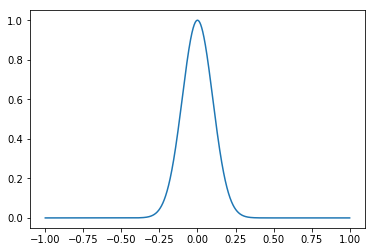

TypeError: generate_gaussian_power_beams() missing 1 required positional argument: 'ub'

In [51]:
x,beam_vis = generate_gaussian_power_beam(0.0,0.1)
plt.plot(x,beam_vis)
plt.show()

means = numpy.asarray([[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0]])
sigmas = numpy.asarray([[0.5],[0.2],[0.5],[0.5],[0.5],[0.5],[0.5],[0.5],[0.5],[0.5],[0.5],[0.5],[0.5],[0.5]])

x,beams_matrix_vis = generate_gaussian_power_beams(locs_uvw,means,sigmas)

In [45]:
def simulate_visibilities(layout,points,beam):
    
    vis_matrix = numpy.zeros(shape=(layout.shape[0],layout.shape[0]),dtype=numpy.complex128)
    
    for i in numpy.arange(layout.shape[0]):
        for j in numpy.arange(layout.shape[0]):        
            
            ud = layout[i,0] - layout[j,0]
            vd = layout[i,1] - layout[j,1]
            wd = layout[i,2] - layout[j,2]
            
            
            
            for p in numpy.arange(points.shape[0]):
            
                lp = points[p,0]
                mp = points[p,1]
                np = numpy.sqrt(1.0 - lp**2+mp**2) - 1.0
                
                b1 = find_beam_at_point(beam,points[p,:]) 
                #print(b1)
                b2 = find_beam_at_point(beam,points[p,:])
                bap = b1 * numpy.conj(b2) # Each antenna has same beam so square
                
                phase_factor = numpy.exp(-2j * numpy.pi * (ud*lp + vd*mp + wd*np))
                point_amp = points[p,2]
                vis_matrix[i,j] += point_amp * bap * phase_factor
                
    return vis_matrix


def simulate_visibilities_beams(layout,points,beams):
    
    vis_matrix = numpy.zeros(shape=(layout.shape[0],layout.shape[0]),dtype=numpy.complex128)
    
    for i in numpy.arange(layout.shape[0]):
        for j in numpy.arange(layout.shape[0]):        
            
            ud = layout[i,0] - layout[j,0]
            vd = layout[i,1] - layout[j,1]
            wd = layout[i,2] - layout[j,2]
            
            
            
            for p in numpy.arange(points.shape[0]):
            
                lp = points[p,0]
                mp = points[p,1]
                np = numpy.sqrt(1.0 - lp**2+mp**2) - 1.0
                b1 = find_beam_at_point(beams[i,:],points[p,:])
                
                b2 = find_beam_at_point(beams[j,:],points[p,:])
                bap = b1 * numpy.conj(b2) # Each antenna has same beam so square
                
                phase_factor = numpy.exp(-2j * numpy.pi * (ud*lp + vd*mp + wd*np))
                point_amp = points[p,2]
                vis_matrix[i,j] += point_amp * bap * phase_factor
                
    return vis_matrix      

In [46]:
vis_mat2 = simulate_visibilities(locs_uvw,numpy.asarray(points),beam_vis)
vis_mat2_db = simulate_visibilities_beams(locs_uvw,numpy.asarray(points),beams_matrix_vis)

beam_matrix_test = numpy.tile(beam[numpy.newaxis,:],(14,1))
vis_mat2_db_test = simulate_visibilities_beams(locs_uvw,numpy.asarray(points),beam_matrix_test)

u, s, vh = numpy.linalg.svd(baselines, full_matrices=True)
print(s)
print(beam_matrix_test.shape)

NameError: name 'beams_matrix_vis' is not defined

In [47]:
vis_mat2.shape

(14, 14)

In [48]:
visibilities.shape

(14, 14)

In [49]:
closures_test = generate_closure_triads_tp(vis_mat2,List_of_antennas)
closures_test2 = generate_closure_triads_tp(vis_mat2_db,List_of_antennas)
closures_test3 = generate_closure_triads_tp(vis_mat2_db_test,List_of_antennas)
print(closures_test)
print(closures_test2)
print(closures_test3)

NameError: name 'vis_mat2_db' is not defined

In [50]:
print(calculate_closure_standard_deviation(closures_test))
print(calculate_closure_standard_deviation(closures_test2))
print(calculate_closure_standard_deviation(closures_test3))

1.4901161193847656e-08


NameError: name 'closures_test2' is not defined

And now it works? FML

In [ ]:
def simulate_visibilities_sky(layout,sky,beam):
    
    vis_matrix = numpy.zeros(shape=(layout.shape[0],layout.shape[0]),dtype=numpy.complex128)
    grid_size = sky.shape[0]
    lm_step = 2/grid_size
    
    
    for i in numpy.arange(layout.shape[0]):
        for j in numpy.arange(layout.shape[0]):        
            
            ud = layout[i,0] - layout[j,0]
            vd = layout[i,1] - layout[j,1]
            wd = layout[i,2] - layout[j,2]            
            
            for lc in numpy.arange(grid_size):
                lp = (lc-grid_size//2) * lm_step
                for mc in numpy.arange(grid_size):
                    mp = (mc-grid_size//2) * lm_step
                    if(lp**2 + mp**2 > 1):
                        continue
                    np = numpy.sqrt(1.0-lp**2-mp**2) - 1.0
                    b1 = find_beam_at_point(beam,[lp,mp,0])
                    b2 = find_beam_at_point(beam,[lp,mp,0])
                    bap = b1 * numpy.conj(b2) # Each antenna has same beam so square
                
                    phase_factor = numpy.exp(-2j * numpy.pi * (ud*lp + vd*mp + wd*np))
                    point_amp = sky[mc,lc]
                    vis_matrix[i,j] += point_amp * bap * phase_factor
                
    return vis_matrix/(grid_size**2)


def simulate_visibilities_beams_sky(layout,sky,beams):
    
    vis_matrix = numpy.zeros(shape=(layout.shape[0],layout.shape[0]),dtype=numpy.complex128)
    grid_size = sky.shape[0]
    lm_step = 2/grid_size
    
    for i in numpy.arange(layout.shape[0]):
        for j in numpy.arange(layout.shape[0]):        
            
            ud = layout[i,0] - layout[j,0]
            vd = layout[i,1] - layout[j,1]
            wd = layout[i,2] - layout[j,2]
            lm_step = 2/grid_size       
            
            for lc in numpy.arange(grid_size):
                lp = (lc-grid_size//2) * lm_step
                for mc in numpy.arange(grid_size):
                    mp = (mc-grid_size//2) * lm_step
                    if(lp**2 + mp**2 > 1):
                        continue
                    np = numpy.sqrt(1.0-lp**2-mp**2) - 1.0
                    b1 = find_beam_at_point(beams[i,:],[lp,mp,0])
                    b2 = find_beam_at_point(beams[j,:],[lp,mp,0])
                    bap = b1 * numpy.conj(b2) # Each antenna has same beam so square
                
                    phase_factor = numpy.exp(-2j * numpy.pi * (ud*lp + vd*mp + wd*np))
                    point_amp = sky[mc,lc]
                    vis_matrix[i,j] += point_amp * bap * phase_factor
                
    return vis_matrix/(grid_size**2)     



In [ ]:
skycont_int = skycont * skycont.conj()

In [ ]:
vismat_sky = simulate_visibilities_sky(locs_uvw, skycont_int, beam)

# Okay let's test closure divergence for beams

In [52]:
def plot_closure_divergence_vs_beamdifferences(locs,ant_list):
    
    points = [[0.2,0.2,80],[0.05,0.3,40],[-0.45,0.45,790],[0.45,0.45,100],[0.45,-0.45,100],
              [-0.45,-0.45,100],[0.5,0.0,100],[0.0,0.5,80],[-0.5,0.0,100],[-0.5,-0.5,100],
              [-0.8,0.0,100],[0.8,0.0,100],[0.21,0.21,80],[0.205,0.205,100]]
    
    
    beam_params = [ [0.25,0.75],
                    [0.4,0.5],
                    [0.425,0.475],
                    [0.44,0.46],
                    [0.448,0.452]]
    
    std_devs = numpy.zeros(shape=5)
    closures = numpy.zeros(shape=(5,numpy.asarray(ant_list).shape[0]))
    av_beam_errors = numpy.zeros(shape=5)
    for i,beam in enumerate(beam_params):
    
        means = numpy.zeros(shape=(locs_uvw.shape[0]))
            
        x,beams,av_beam_error = generate_gaussian_power_beams(locs,means,beam[0],beam[1])
        av_beam_errors[i] = av_beam_error
        vismat = simulate_visibilities_beams(locs,numpy.asarray(points),beams)
        closures[i,:] = generate_closure_triads_tp(vismat,ant_list)
        std_devs[i] = calculate_closure_standard_deviation(closures[i,:])
        
    ticklabels = numpy.char.mod("%.2f",100*av_beam_errors) # Aaah numpy, your mysteries are deep and endless
    indices = numpy.arange(5)
    fig = plt.figure(figsize=(12,5))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    for i in indices:
        ir = numpy.full(closures.shape[1],i)
        ax1.scatter(ir,closures[i,:],c='b',marker='x')
    ax1.set_ylim(-numpy.pi,numpy.pi)
    fig.suptitle('Closure Phase vs Beam Error')
    ax1.set_xlabel('Average Error Between Beams (%)')
    ax1.set_ylabel('Phase (Radians)')
    ax1.set_xticks(indices)
    ax1.set_xticklabels(ticklabels)
    ax2.bar(indices,std_devs)
    ax2.set_xticks(indices)
    ax2.set_xticklabels(ticklabels)
    ax2.set_xlabel('Average Error Between Beams(%)')
    ax2.set_ylabel('Circular Standard Deviation (Radians)')
    plt.savefig("beamerror.pdf")
    plt.show()
        
    print(closures)
    print(std_devs)

0.08318724861869196
0.03006927651432446
0.012554097535441542
0.005343032942445921
0.0006314313270079808


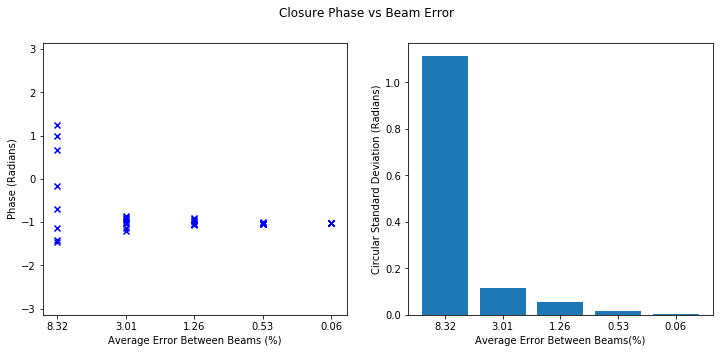

[[-0.17113897  0.99431019  1.25528167 -1.40618914  0.67079212 -1.12809734
  -0.68457941 -1.45317564]
 [-0.90375625 -1.21337271 -1.04528709 -1.00778761 -0.86725034 -0.9410508
  -1.13677701 -0.91052178]
 [-0.92731994 -0.90046232 -0.97545581 -1.04476305 -1.06091847 -1.04895809
  -1.04050131 -0.97923733]
 [-1.04569841 -1.03435361 -1.00376625 -1.04565893 -1.02120784 -1.04329266
  -1.01619353 -1.03493219]
 [-1.01228267 -1.01207147 -1.01382436 -1.01178807 -1.01257514 -1.01574071
  -1.01770175 -1.01950061]]
[1.1139315  0.11442232 0.05692324 0.01442446 0.00271785]


In [58]:
plot_closure_divergence_vs_beamdifferences(locs_uvw,List_of_antennas)

In [54]:
def plot_closure_divergence_vs_nsr(locs,ant_list):
    
    points = [[0.2,0.2,80],[0.05,0.3,40],[-0.45,0.45,790],[0.45,0.45,100],[0.45,-0.45,100],
              [-0.45,-0.45,100],[0.5,0.0,100],[0.0,0.5,80],[-0.5,0.0,100],[-0.5,-0.5,100],
              [-0.8,0.0,100],[0.8,0.0,100],[0.21,0.21,80],[0.205,0.205,100]]
    
    
    nsr_params = [0.0,
                  0.001,
                  0.01,
                  0.1,
                  1.0,
                  10.0,
                  100.0]
    
    std_devs = numpy.zeros(shape=len(nsr_params))
    closures = numpy.zeros(shape=(len(nsr_params),numpy.asarray(ant_list).shape[0]))
    for i,nsr in enumerate(nsr_params):
    
        means = numpy.zeros(shape=(locs_uvw.shape[0]))
            
        x,beam = generate_gaussian_power_beam(0.0,1.0)
                           
        
        vismat = simulate_visibilities(locs,numpy.asarray(points),beam)
        #Simulate correlated gaussian noise
        autocorrs = numpy.diagonal(vismat)
        av_power = numpy.mean(autocorrs)
                           
        noise_scale_factor = av_power * nsr
        additive_correlated_noise = noise_scale_factor * (numpy.random.standard_normal((locs_uvw.shape[0],locs_uvw.shape[0])) + 
                           1j*numpy.random.standard_normal((locs_uvw.shape[0],locs_uvw.shape[0])))
        vismat += additive_correlated_noise
                           
                           
        closures[i,:] = generate_closure_triads_tp(vismat,ant_list)

        std_devs[i] = calculate_closure_standard_deviation(closures[i,:])
        
    ticklabels = numpy.char.mod("%.1f",100*numpy.asarray(nsr_params)) # Aaah numpy, your mysteries are deep and endless
    indices = numpy.arange(len(nsr_params))
    
    fig = plt.figure(figsize=(12,6))
    fig.suptitle('Closure Phase vs Noise-Signal Ratio (NSR) ')
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    for i in indices:
        ir = numpy.full(closures.shape[1],i)
        ax1.scatter(ir,closures[i,:],c='b',marker='x')
    ax1.set_ylim(-numpy.pi,numpy.pi)
    
    ax1.set_xlabel('NSR (%)')
    ax1.set_ylabel('Phase (Radians)')
    ax1.set_xticks(indices)
    ax1.set_xticklabels(ticklabels)
    ax2.bar(indices,std_devs)
    ax2.set_xticks(indices)
    ax2.set_xticklabels(ticklabels)
    ax2.set_xlabel('NSR (%)')
    ax2.set_ylabel('Circular Standard Deviation (Radians)')
    plt.savefig("nsrplot.pdf")
    plt.show()
        
    print(closures)
    print(std_devs)

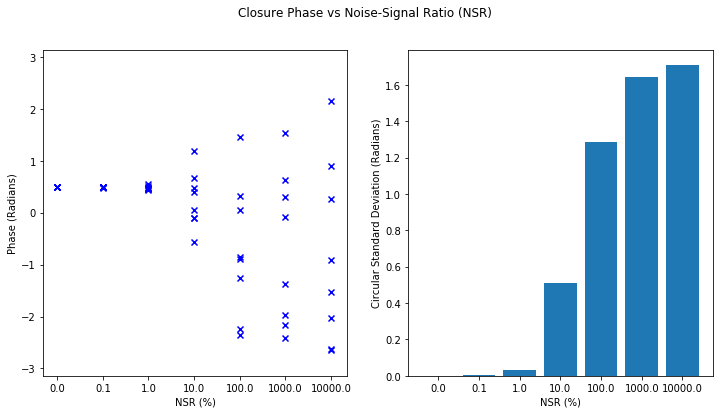

[[ 0.48643737  0.48643737  0.48643737  0.48643737  0.48643737  0.48643737
   0.48643737  0.48643737]
 [ 0.49107362  0.49506816  0.48001596  0.48671674  0.48745889  0.48929421
   0.49391138  0.48843028]
 [ 0.45957683  0.54489485  0.43319718  0.50642158  0.47940807  0.47757876
   0.47786874  0.4502761 ]
 [ 0.40402704  0.0431566  -0.11042919 -0.09239306  0.47410576 -0.55463251
   0.66727619  1.1937847 ]
 [-0.8939413  -2.35765763 -0.85954985 -2.24018373  0.04366862  1.46179681
  -1.26719208  0.31253783]
 [ 0.62503055 -1.9615459  -1.36630753  1.53697926 -2.16493832 -2.41612845
  -0.07878554  0.29563949]
 [-0.91781829  2.14984584 -2.61750122 -2.64573264  0.89925038 -1.52272446
  -2.02346012  0.25496976]]
[-0.          0.00438686  0.03239777  0.51293437  1.28483086  1.64477968
  1.70790519]


In [55]:
#plot_closure_divergence_vs_nsr
plot_closure_divergence_vs_nsr(locs_uvw,List_of_antennas)

In [56]:
def plot_efield_locs_triads(locs,ant_list):
    
    locs_uvw = locs/wavelength
    baselines = generate_baseline_vectors(locs_uvw)
    
    us = locs[:,0]
    vs = locs[:,1]
    ws = locs[:,2]
    
    us_uvw = baselines[:,:,0]
    vs_uvw = baselines[:,:,1]
    ws_uvw = baselines[:,:,2]

    fig = plt.figure(figsize=(12,5))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    
    ax1.scatter(us, vs, color='blue')
    
    for i in numpy.arange(locs.shape[0]):
        ax1.annotate(i,xy=(locs[i,0],locs[i,1]),xytext=(locs[i,0] + 2, locs[i,1] +0.75))
    
    for antenna in ant_list:
        bl1 = antenna[0]
        bl2 = antenna[1]
        bl3 = antenna[2]
        
        ax1.plot([us[bl1[0]],us[bl1[1]]],[vs[bl1[0]],vs[bl1[1]]],'r--')
        ax1.plot([us[bl2[0]],us[bl2[1]]],[vs[bl2[0]],vs[bl2[1]]],'r--')
        ax1.plot([us[bl3[0]],us[bl3[1]]],[vs[bl3[0]],vs[bl3[1]]],'r--')
    
    ax1.set_title('Electric Field Locations')
    ax1.set_xlim([-40,40])
    ax1.set_ylim([-40,40])
    ax1.set_xlabel('u'); ax.set_ylabel('v');
    
    ax2.scatter(us_uvw, vs_uvw, color='blue', marker='^')
    ax2.set_title('Baseline Locations at 140 MHz')
    ax2.set_xlim([-30,30])
    ax2.set_ylim([-30,30])
    ax2.set_xlabel('u'); ax.set_ylabel('v')
    
    plt.savefig('ant_bl_locs.pdf')
    plt.show()

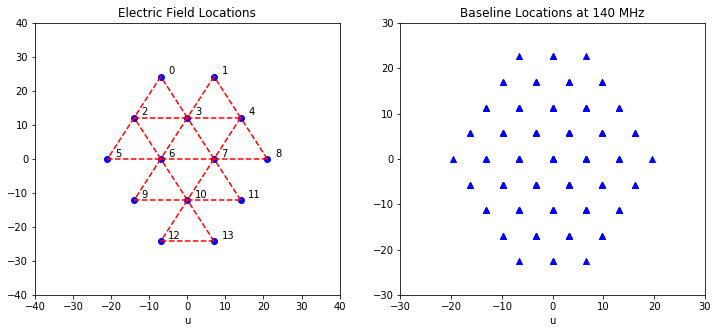

In [57]:
plot_efield_locs_triads(locs,List_of_antennas)